# Imports

In [1]:
from numpy import bincount
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm as progress
from torch.nn.functional import relu
from torch.nn.utils import clip_grad_norm_ 
from pandas import read_csv, DataFrame, concat
from sklearn.model_selection import train_test_split
from torch.nn import ModuleList, Embedding, Dropout, Linear, Sigmoid, BCELoss
from torch import device, cuda, IntTensor, FloatTensor, flatten, sigmoid, save, load, no_grad
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Constant Variables
batch_size = 4096
device = device("cuda" if cuda.is_available() else "cpu")

# Loading SMS Data

In [2]:
df = read_csv("../../data/sms.csv")
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,text,type
2096,"[10, 333, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
575,"[24, 3, 15, 3, 3, 3, 162, 24, 3, 15, 3, 3, 3, ...",1
5272,"[337, 17, 57, 24, 57, 3, 24, 57, 224, 451, 161...",0
5526,"[691, 4, 3, 3, 3, 3, 692, 693, 575, 3, 3, 3, 1...",1
1216,"[3, 414, 2796, 17, 322, 133, 3, 3, 3, 3, 3, 3,...",1


# Preparing SMS Data


In [3]:
# Load & Prepare Data
df["text"] = df["text"].apply(lambda sms: [int(word) for word in sms[1:-1].split(", ")])
df["type"] = df["type"].apply(lambda label: int(label))

# # Train / Valid / Test Split
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["type"], test_size=0.30, stratify=df["type"], random_state=2022)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify=y_test, random_state=2022)

# Training weight
train_weight = (1./bincount(y_train))[y_train]

# Train / Valid / Test TensorDataset
train_dataset = TensorDataset(IntTensor(x_train.to_list()), FloatTensor(y_train.to_list()))
valid_dataset =  TensorDataset(IntTensor(x_valid.to_list()), FloatTensor(y_valid.to_list()))
test_dataset = TensorDataset(IntTensor(x_test.to_list()), FloatTensor(y_test.to_list()))

# Train / Test / Valid Loaders
train_loader = DataLoader(train_dataset, sampler=WeightedRandomSampler(train_weight, len(train_weight)-1), batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Model

In [4]:
class SMSClassifier(ModuleList):
    def __init__(self, path):
        super(SMSClassifier, self).__init__()
        self.path = path
        self.embedding = Embedding(num_embeddings=6260, embedding_dim=8, padding_idx=0)
        self.dropout1 = Dropout(0.5)
        self.fc1 = Linear(2400, 1200)
        self.fc2 = Linear(1200, 600)
        self.fc3 = Linear(600, 1)

    def forward(self, sentence):
        sentence = self.embedding(sentence)
        sentence = self.dropout1(sentence)
        sentence = flatten(sentence, start_dim=1)
        sentence = self.fc1(sentence)
        sentence = relu(sentence, inplace=True)
        sentence = self.fc2(sentence)
        sentence = relu(sentence, inplace=True)
        sentence = self.fc3(sentence).squeeze()
        return sigmoid(sentence)

    def fit(self, loaders, epochs, optim, loss_fn, train_loss=[1], valid_loss=[1], best_epoch=0):
        for epoch in (tracker := progress(range(epochs))):
            tracker.set_description(f"Epoch #{epoch+1}")
            # Train Step
            train_loss.append(self.train_step(loaders[0], optim, loss_fn))
            # Eval Step
            valid_loss.append(self.eval_step(loaders[1], loss_fn))
            # Saving Model If Performance Improves
            if valid_loss[-1] <= min(valid_loss):
                best_epoch = epoch
                self.save()
            # Updating tracker
            if epoch == epochs-1:
                tracker.set_description(f"Best Epoch #{best_epoch+1}")
                tracker.set_postfix_str(f"Training Loss = {train_loss[best_epoch]}, Validiation Loss = {valid_loss[best_epoch]}")
            else:
                tracker.set_postfix_str(f"Training Loss = {train_loss[-1]}, Validiation Loss = {valid_loss[-1]}")
            
        # Plotting Results
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.set_title("Training Loss (Blue) vs Validation Loss (Red)")
        ax.plot(train_loss, "b")
        ax.plot(valid_loss, "r")
        ax.set_xlim((0, len(train_loss)-1))
        ax.set_ylim((0, max(train_loss)))
        plt.show()

    def train_step(self, loader, optim, loss_fn, losses=[]):
        self.train()
        for step, batch in enumerate(loader):
            self.zero_grad()
            # Training Step
            prediction = self.forward(batch[0].to(device))
            loss = loss_fn(prediction, batch[1].type(FloatTensor).to(device))
            # Recording Training Result
            losses.append(loss.item())
            # Refresh Step
            loss.backward()
            clip_grad_norm_(self.parameters(), max_norm=1.0, norm_type=1)
            optim.step()
        return sum(losses)/len(losses)

    def eval_step(self, loader, loss_fn, losses=[]):
        self.eval()
        with no_grad():
            for step, batch in enumerate(loader):
                # Evaluation Step
                prediction = self.forward(batch[0].to(device))
                loss = loss_fn(prediction, batch[1].type(FloatTensor).to(device))
                # Recording Evaluation Result
                losses.append(loss.item())       
        return sum(losses)/len(losses)

    def evaluate(self, loader, y_true=[], y_pred=[]):
        self.load()
        self.eval()
        with no_grad():
            for step, batch in enumerate(loader):
                y_pred.extend([int(pred > 0.5) for pred in self.forward(batch[0].to(device)).cpu().numpy()])
                y_true.extend(batch[1])
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        rc1, rc2, rc3 = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(rc2,  rc1)
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nPR_AUC: {pr_auc}")
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0, 1]).plot()
        plt.show()
        return accuracy, precision, recall, pr_auc
    
    def saveResults(self, lib, nam, typ, acc, pre, rec, pr):
        df = read_csv("../../data/results.csv")
        df2 = DataFrame([[lib, nam, typ, acc, pre, rec, pr]], 
                        columns=["Library", "Model", "Type", "Accuracy", "Precision", "Recall", "PR_AUC"])
        df = concat([df2, df])
        if "Unnamed: 0" in df:
            df = df.drop(columns=["Unnamed: 0"])
        df.to_csv("../../data/results.csv")

    def save(self):
        save(self.state_dict(), self.path)

    def load(self):
        self.load_state_dict(load(self.path))

# Model Summary

In [5]:
model = SMSClassifier(path="../../models/nn.pt").to(device)
model

SMSClassifier(
  (embedding): Embedding(6260, 8, padding_idx=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2400, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=1, bias=True)
)


# Model Training 

Best Epoch #102: 100%|██████████| 300/300 [00:22<00:00, 13.63it/s, Training Loss = 0.0910784445483895, Validiation Loss = 0.19595154462491765]  


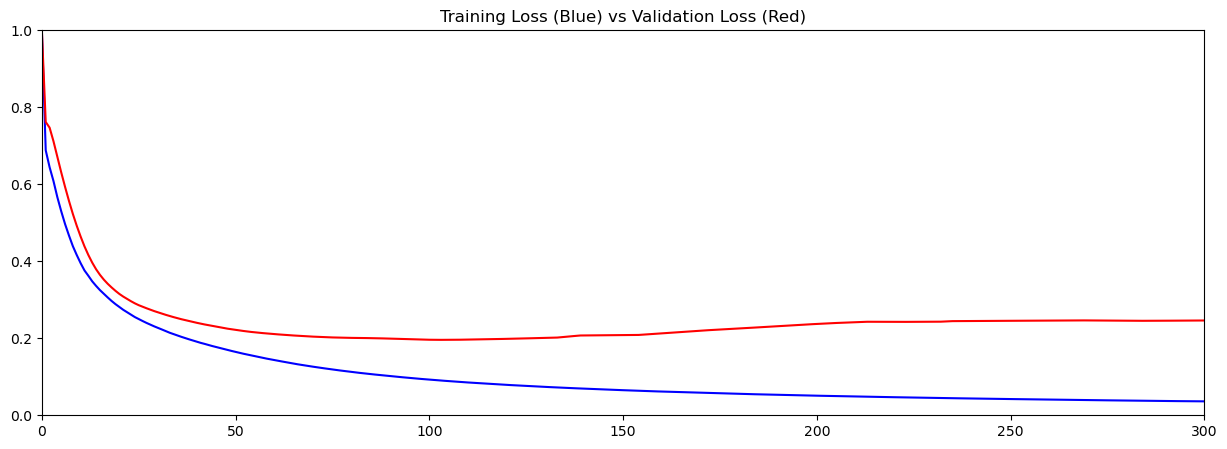

In [6]:
model.fit([train_loader, valid_loader], 300, AdamW(model.parameters(), lr=1e-3), BCELoss())

# Model Evaluation

Train Results
Accuracy: 0.9997435239805078
Precision: 0.9994861253854059
Recall: 1.0
PR_AUC: 0.999743062692703


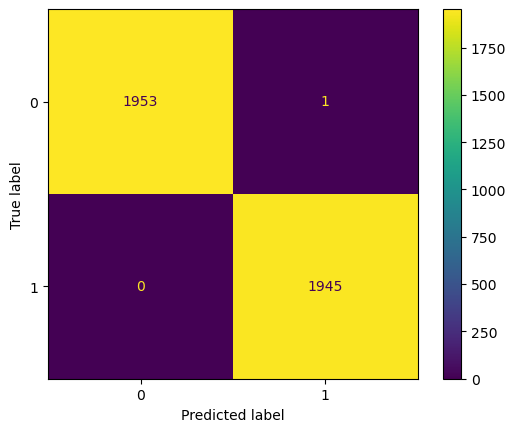

In [7]:
print("Train Results")
acc, pre, re, pr = model.evaluate(train_loader)
model.saveResults("pytorch", "nn", "train", acc, pre, re, pr)

Valid Results
Accuracy: 0.9996152859707618
Precision: 0.9992313604919293
Recall: 1.0
PR_AUC: 0.9996156802459646


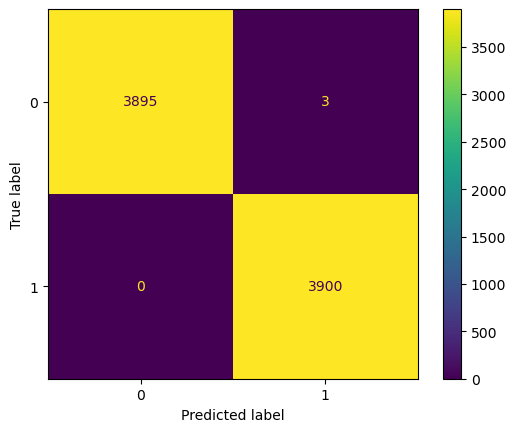

In [8]:
print("Valid Results")
acc, pre, re, pr = model.evaluate(train_loader)
model.saveResults("pytorch", "nn", "valid", acc, pre, re, pr)

Test Results
Accuracy: 0.9996580319740104
Precision: 0.999314716463937
Recall: 1.0
PR_AUC: 0.9996573582319686


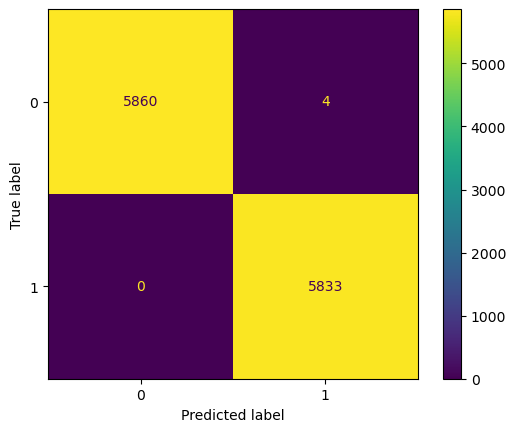

In [9]:
print("Test Results")
acc, pre, re, pr = model.evaluate(train_loader)
model.saveResults("pytorch", "nn", "test", acc, pre, re, pr)